### Aim: Identify BETTER cities by air_temperature for the primary use of filling missing test data and to obtain Lat-Long co-ordinates.

I took patrick0302's https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature notebook and used this to do some more digging around each meter. I also combined this with the information linked to ASHRAE Regions as highlighted by Alexey in his discussion https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113338#latest-659249. I mainly used this pdf: https://www.ashrae.org/File%20Library/Communities/Regions/Chapters-by-Region-and-Location.PDF.

I then used this to make informed guesses where each site was located, then went in search of that data. It was a bit of a painful process but here are my results!!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20, 16

In [2]:
weather = pd.read_csv(
    '../../data/weather_train.csv'
)

weather.timestamp = pd.to_datetime(weather.timestamp, format='%Y-%m-%d %H:%M:%S')

weather_test = pd.read_csv(
    "../../data/weather_test.csv"
)

weather_test.timestamp = pd.to_datetime(weather_test.timestamp, format='%Y-%m-%d %H:%M:%S')

Firstly, I wanted to have a little look at which temperature meters most needed extra data. It seems reasonable to me that we can linearly interpolate two time steps and forward and backfill one.

In [3]:
weath = pd.concat([weather, weather_test]).set_index(['site_id', 'timestamp'])

weath = weath.reindex(
    pd.MultiIndex.from_product(
        [range(16), pd.date_range('2016-01-01', '2018-12-31 23:00', freq='H')])
)

weath = weath.unstack(level=0).interpolate(limit=2).ffill(limit=1).bfill(limit=1)

Now I wish to find which temperture meters have large missing gaps in the weather_test set. I am happy to remove consecutive missing data from the training set, but this won't do for the tet set at inference time.

Here I will search for the largest consecutive ranges of missing data.

In [4]:
w = weather_test.set_index(['site_id', 'timestamp'])
w = w.unstack('site_id')

to_lieaner_interp = []
to_lieaner_interp_idx = []

for col, S in w.iteritems():
    to_lieaner_interp.append(
        S.isnull().astype(int).groupby(S.notnull().astype(int).cumsum()).sum().max()
    )

    to_lieaner_interp_idx.append(col)

pd.DataFrame(to_lieaner_interp, index=pd.MultiIndex.from_tuples(to_lieaner_interp_idx)).unstack(0).rename(columns={0: 'max_consecutive_nans'}, level=0)

max_consecutive_nans                                                   \
        air_temperature cloud_coverage dew_temperature precip_depth_1_hr   
0                     0             64               0                 8   
1                   149            741             149             17520   
2                     0             67               1                10   
3                     1             64               1                24   
4                     1            135               2               131   
5                   149            221             149             17520   
6                     5             97               5                13   
7                   202          17520             202               453   
8                     0             64               0                 8   
9                    21            199              39                26   
10                    8            136               8                14   
11                  202          17520             202               453   
12                  149            149             149             17520   
13                    1             94               1               186   
14                    2             93               2                23   
15                    8            166               8               292   

                                                 
   sea_level_pressure wind_direction wind_speed  
0                  33              4          1  
1                 149            149        149  
2                   2              5          1  
3                  12              3          1  
4                   3              3          1  
5               17520            149        149  
6                   5              6          5  
7                 203            202        202  
8                  33              4          1  
9                  34             23         22  
10                 22             16         11  
11                203            202        202  
12                149            149        149  
13                  2              4          1  
14                  3              4          2  
15                277              8          8

I am only focusing on `air_temperature`, for now, as I believe it will be the main driver for most gas, steam and hot water meters.

Here it is clear we need to focus our attention on site_ids: **1, 5, 7, 11, 12** and maybe **9**.

Lets get some extra data!! (Here I spent a while fiddling with some clunky APIs in order to get the temperature data I wanted).

In [5]:
fill_weather = pd.read_csv(
    '../../data/historical-hourly-weather-data/more_weather_locations.csv',
    index_col=0,
    parse_dates=True,
    infer_datetime_format=True,
).join(
    pd.read_csv(
        '../../data/historical-hourly-weather-data/temperature.csv',
        index_col=0,
        parse_dates=True,
        infer_datetime_format=True,
    ).sub(273),
    how='left',
)

In [6]:
weath_corr = fill_weather.join(weath.air_temperature).corr().drop(range(16)).loc[:, range(16)]

site_id_loc_corr = pd.concat([weath_corr.idxmax(), weath_corr.max()], keys=['location', 'corr'], axis=1).rename_axis('site_id')
site_id_loc_corr

,location,corr
site_id,,
0,orlando,0.971346
1,heathrow,0.985568
2,Phoenix,0.978950
3,washington,0.990834
4,San Francisco,0.927506
5,birmingham,0.944360
6,washington,0.976488
7,ottowa,0.990955
8,orlando,0.971346


This is a good improvement on patricks excellent work, which had an average corr of **0.915** or **0.954** excluding the Isreali cities, vs my **0.975** average corr.

In [7]:
site_id_loc_corr.mean()

corr    0.974897
dtype: float64

While the corr function was excellent for finding correlations between places, my guess is that, for data filling purposes, it might not be the best metric. This is because there could be a level shift between two highly correlated temperatures. See San Francisco, sanfranintl (international airport) and site 4 over the summer, as shown below, 2016 for comparision.

This has driven me to use the RMSE as a metric for deciding on how best to fill missing test data.

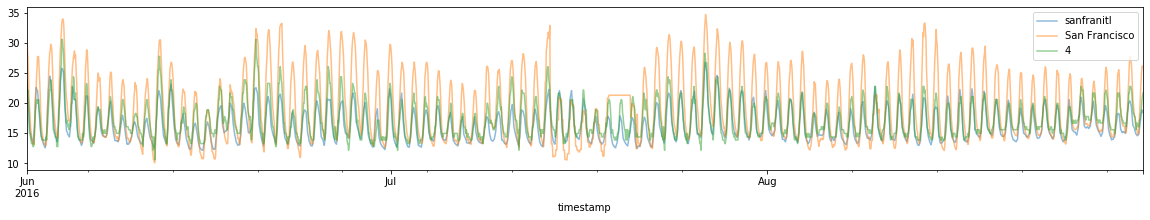

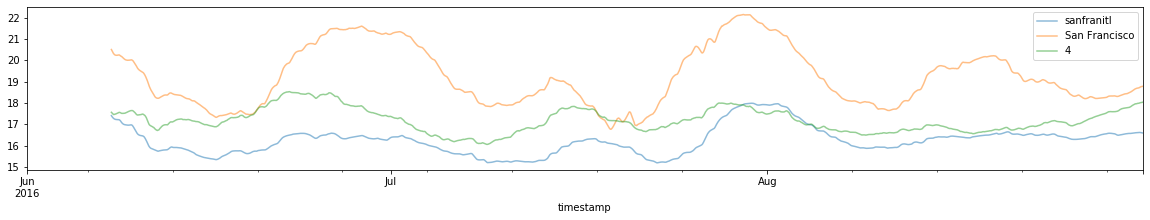

In [19]:
fill_weather.join(weath.air_temperature).loc['2016-06':'2016-08', ['sanfranitl', 'San Francisco', 4]].plot(alpha=.5, figsize=(20, 3))
fill_weather.join(weath.air_temperature).loc['2016-06':'2016-08', ['sanfranitl', 'San Francisco', 4]].rolling(168).mean().plot(alpha=.5, figsize=(20, 3))
plt.show()

In [9]:
site_dict  = {}

for loc_name, loc_S in fill_weather.iteritems():
    site_scores = []
    for site_id, site_S in weath.air_temperature.iteritems():
        df = loc_S.to_frame(loc_name).join(site_S)
        site_scores.append(df.diff(axis=1).pow(2).mean().pow(0.5).iat[1])

    site_dict[loc_name] = site_scores

temp_rmse = pd.DataFrame(site_dict, index=range(16))

In [10]:
# remove missing data temperature set for San Antonio (site_9) as this is a site in need of test temperature filling.
# "Historical Weather" dataset only goes back to 2017.

# temp_rmse = temp_rmse.drop('San Antonio', axis=1)

In [11]:
site_loc_rmse = pd.concat([temp_rmse.idxmin(axis=1), temp_rmse.min(axis=1)], keys=['location', 'RMSE'], axis=1).rename_axis('site_id')
site_loc_rmse

,location,RMSE
site_id,,
0,orlando,1.488840
1,heathrow,1.258968
2,Phoenix,2.468675
3,washington,1.848207
4,sanfranitl,1.691886
5,birmingham,2.032724
6,washington,2.355381
7,ottowa,1.646181
8,orlando,1.488840


In [12]:
site_loc_rmse_dict = site_loc_rmse.location.to_dict()

weather_test_new = {}

for site_id, S in weather_test.set_index(['site_id', 'timestamp']).air_temperature.unstack(level=0).iteritems():
    weather_test_new[site_id] = S.fillna(fill_weather.loc[:, site_loc_rmse_dict[site_id]])

weather_test_new = pd.DataFrame(weather_test_new)

In [13]:
lat_long = {
    'orlando': (28.512274, -81.40619),
    'heathrow': (51.471092, -0.455046),
    'Phoenix': (33.474250, -112.077456),
    'washington': (38.8973, -77.02894),
    'sanfranitl': (37.62, -122.365),
    'birmingham': (52.452442, -1.743035),
    'ottowa': (45.414524, -75.711136),
    'sanantonio': (29.419, -98.489),
    'saltlake': (40.894524, -111.88771),
    'dublin': (53.3498, -6.2603),
    'Minneapolis': (44.973814, -93.265767),
    'Philadelphia': (39.958187, -75.15964),
    'rochester': (43.161617, -77.60488),
}

In [17]:
w = weather_test_new

to_lieaner_interp = []
to_lieaner_interp_idx = []

for col, S in w.iteritems():
    to_lieaner_interp.append(
        S.isnull().astype(int).groupby(S.notnull().astype(int).cumsum()).sum().max()
    )

    to_lieaner_interp_idx.append(col)

results = pd.DataFrame(to_lieaner_interp).rename(columns={0: 'max_consecutive_nans'}, level=0).rename_axis('site_id').join(site_loc_rmse)
results['lat_long'] = results.location.map(lat_long)
results.to_csv('../../data/cities_info.csv')